In [2]:
import time
from pathlib import Path

import cv2
import numpy as np
import time
import tensorflow as tf
import os
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt
from IPython.display import Markdown
from openvino.inference_engine import IECore
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.python.tools import freeze_graph
import tf2onnx
import onnx

In [62]:
PATH_TO_SAVED_MODEL = "./models/effdet/saved_model"
PATH_TO_LABELS = "./labels.txt"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Suppress TensorFlow logging (1)
tf.get_logger().setLevel("ERROR")  # Suppress TensorFlow logging (2)

## Inference using Tensorflow Model

In [63]:
model = tf.saved_model.load(PATH_TO_SAVED_MODEL)

In [64]:
model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f5226e15610>

In [50]:
# def detect_signs(img:np.ndarray, model, labels:List[str]):
#     shapes, predictions_dict, detections, _ = model([img])

#     label_id_offset = 1

#     if predictions_dict[0][0] > 0.85:

#         box = (
#             (int(shapes[0][0][1]), int(shapes[0][0][0])),
#             (int(shapes[0][0][3]), int(shapes[0][0][2])),
#         )
#         text = labels[int(detections[0][0].numpy()) - label_id_offset]
#         location = (int(shapes[0][0][1]), int(shapes[0][0][0]))
#         return box, text, location

#     return None

# def draw_box(img,box, text, location):
#     fontScale = 10
#     color = (255, 0, 0)
#     thickness = 8
#     font = cv2.FONT_HERSHEY_SIMPLEX

#     retimg = cv2.rectangle(img, box[0], box[1], color, thickness)
#     retimg = cv2.putText(
#         retimg, text, location, font, fontScale, color, thickness, cv2.LINE_AA
#     )
#     return retimg

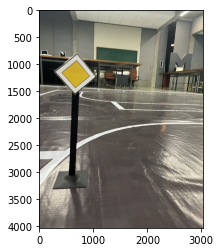

In [51]:
# img = cv2.imread("IMG_1166.JPG")
# img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# # plt.imshow(img)

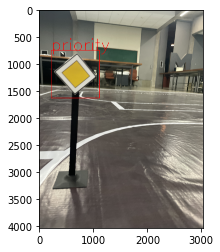

In [52]:
# box,text,loc = detect_signs(img, model, labels)
# final_img = draw_box(img, box,text,loc)
# plt.imshow(final_img)

## Convert Tensorflow Model to ONNX  

In [65]:
def freeze_tf(model_path:str, dir_path:str, filename:str) -> str:
    """Load model from model_path and save as Frozen Graph
    Args:
        model_path: path to tensorflow saved_model dir
        dir_path: directory to save frozen model
        filename: filename
    Returns:
        file_path: path to (.pb) frozen model 
    """
    model = tf.saved_model.load(model_path)
    full_model = tf.function(lambda x: model(x))
    full_model = full_model.get_concrete_function(
        tf.TensorSpec(
            model.signatures['serving_default'].inputs[0].shape.as_list(), 
            model.signatures['serving_default'].inputs[0].dtype.name
        )
    )
    frozen_func = convert_variables_to_constants_v2(full_model)   
    frozen_func.graph.as_graph_def()
    
    layers = [op.name for op in frozen_func.graph.get_operations()]
    print("-" * 60)
    print("Frozen model layers: ")
    for layer in layers:
        print(layer)
    
    print("-" * 60)
    print("Frozen model inputs: ")
    print(frozen_func.inputs)
    print("Frozen model outputs: ")
    print(frozen_func.outputs)
    
    # Save frozen graph to disk
    path = tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                      logdir=dir_path,
                      name=f"{filename}.pb",
                      as_text=False)# Save its text representation
    
    tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                      logdir=dir_path,
                      name=f"{filename}.pbtxt",
                      as_text=True)
    return path

frozen_model_path = freeze_tf(PATH_TO_SAVED_MODEL, dir_path="", filename="model-tf")

frozen_model_path

------------------------------------------------------------
Frozen model layers: 
x
1237353
1237355
1237369
1237361
1237371
1237365
1237373
1237357
1237375
1237359
1237377
1237367
1237379
1237363
1237381
Func/StatefulPartitionedCall/input_control_node/_0
Func/StatefulPartitionedCall/StatefulPartitionedCall/input_control_node/_875
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/PadOrClipBoxList/zeros_7/shape_as_tensor
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/PadOrClipBoxList/zeros_7/Const
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/PadOrClipBoxList/zeros_7
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/PadOrClipBoxList/sub_13/x
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/PadOrClipBoxList/zeros_6/shape_as_tensor
StatefulPartitionedCall/Stat

Func/StatefulPartitionedCall/StatefulPartitionedCall/input/_1313
StatefulPartitionedCall/StatefulPartitionedCall/EfficientDet-D1/bifpn/node_03/1_dn_lvl_5/post_combine/separable_conv/BiasAdd/ReadVariableOp
StatefulPartitionedCall/StatefulPartitionedCall/EfficientDet-D1/bifpn/node_03/1_dn_lvl_5/post_combine/separable_conv/BiasAdd
1236817
Func/StatefulPartitionedCall/input/_439
Func/StatefulPartitionedCall/StatefulPartitionedCall/input/_1314
StatefulPartitionedCall/StatefulPartitionedCall/EfficientDet-D1/bifpn/node_03/1_dn_lvl_5/post_combine/batchnorm/ReadVariableOp
1236819
Func/StatefulPartitionedCall/input/_440
Func/StatefulPartitionedCall/StatefulPartitionedCall/input/_1315
StatefulPartitionedCall/StatefulPartitionedCall/EfficientDet-D1/bifpn/node_03/1_dn_lvl_5/post_combine/batchnorm/ReadVariableOp_1
1236821
Func/StatefulPartitionedCall/input/_441
Func/StatefulPartitionedCall/StatefulPartitionedCall/input/_1316
StatefulPartitionedCall/StatefulPartitionedCall/EfficientDet-D1/bifpn/node_

StatefulPartitionedCall/StatefulPartitionedCall/MultiscaleGridAnchorGenerator/GridAnchorGenerator_4/Meshgrid_2/Tile_1
StatefulPartitionedCall/StatefulPartitionedCall/MultiscaleGridAnchorGenerator/GridAnchorGenerator_4/stack
StatefulPartitionedCall/StatefulPartitionedCall/MultiscaleGridAnchorGenerator/GridAnchorGenerator_4/Reshape_2/shape
StatefulPartitionedCall/StatefulPartitionedCall/MultiscaleGridAnchorGenerator/GridAnchorGenerator_4/Reshape_2
StatefulPartitionedCall/StatefulPartitionedCall/MultiscaleGridAnchorGenerator/GridAnchorGenerator_4/mul_5/x
StatefulPartitionedCall/StatefulPartitionedCall/MultiscaleGridAnchorGenerator/GridAnchorGenerator_4/Meshgrid/Const
StatefulPartitionedCall/StatefulPartitionedCall/MultiscaleGridAnchorGenerator/GridAnchorGenerator_4/Meshgrid/Shape
StatefulPartitionedCall/StatefulPartitionedCall/MultiscaleGridAnchorGenerator/GridAnchorGenerator_4/Meshgrid/ExpandedShape/Slice/begin
StatefulPartitionedCall/StatefulPartitionedCall/MultiscaleGridAnchorGenerator

StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/MultiClassNonMaxSuppression/strided_slice_139/stack_1
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/MultiClassNonMaxSuppression/strided_slice_139/stack_2
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/MultiClassNonMaxSuppression/strided_slice_139
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/MultiClassNonMaxSuppression/Minimum_69
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/MultiClassNonMaxSuppression/non_max_suppression_with_scores_69/iou_threshold
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/MultiClassNonMaxSuppression/non_max_suppression_with_scores_69/score_threshold
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonM

StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/PadOrClipBoxList/Slice_5
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/PadOrClipBoxList/Shape_11
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/PadOrClipBoxList/strided_slice_19/stack
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/PadOrClipBoxList/strided_slice_19/stack_1
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/PadOrClipBoxList/strided_slice_19/stack_2
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/PadOrClipBoxList/strided_slice_19
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/PadOrClipBoxList/sub_19
StatefulPartitionedCall/StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/PadOrCl

'model-tf.pb'

## Convert Frozen Model to OpenVINO IR Format

In [66]:
# The paths of the source and converted models
# model_path = Path("nbs/models/saved_model/saved_model.pb")
frozen_model_path = Path(frozen_model_path)
ir_path = Path(frozen_model_path).with_suffix(".xml")

In [67]:
# LOG_DIR = 'logs'  # The path where you want to save tensorboard events

# with tf.Session() as sess:
#     model_filename = frozen_model_path # your model path
#     with gfile.FastGFile(model_filename, 'rb') as f:
#         graph_def = tf.GraphDef()
#         graph_def.ParseFromString(f.read())
#         g_in = tf.import_graph_def(graph_def)
# train_writer = tf.summary.FileWriter(LOG_DIR)
# train_writer.add_graph(sess.graph)

In [68]:
# img.shape

In [71]:
frozen_model_path

PosixPath('model-tf.pb')

In [3]:
# Construct the command for Model Optimizer

# 
# --input_shape "[ 1, 640, 640,  3]"
      
# --output_dir "{frozen_model_path.parent}"
                
mo_command = f"""mo
                --tensorflow_object_detection_api pipeline.config
                --saved_model_dir  ./models/effdet/saved_model
                --reverse_input_channels
                --input_shape "[ 1, 640, 640,  3]"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert TensorFlow to OpenVINO:")
display(Markdown(f"`{mo_command}`"))

Model Optimizer command to convert TensorFlow to OpenVINO:


`mo --tensorflow_object_detection_api pipeline.config --saved_model_dir ./models/effdet/saved_model --reverse_input_channels --input_shape "[ 1, 640, 640, 3]"`

In [108]:
# Run Model Optimizer if the IR model file does not exist
if not ir_path.exists():
    print("Exporting TensorFlow model to IR... This may take a few minutes.")
    ! $mo_command
else:
    print(f"IR model {ir_path} already exists.")

Exporting TensorFlow model to IR... This may take a few minutes.
/bin/bash: /home/alpha91/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/home/alpha91/data/codes/Brain/nbs/.
	- IR output name: 	saved_model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[ 1, 640, 640, 3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	True
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared librarie

In [25]:
!ls temp

/bin/bash: /home/alpha91/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
model2.pb  model2.pbtxt


## Load Model

In [35]:
ir_model_path = "./temp/model2.xml"

ie = IECore()

net = ie.read_network(
    model=ir_model_path
)
exec_net = ie.load_network(net, "CPU")
output_layer_ir = next(iter(exec_net.outputs))
input_layer_ir = next(iter(exec_net.input_info))

Exception: Path to the model ./temp/model2.xml doesn't exist or it's a directory

In [18]:
input_layer_ir

NameError: name 'input_layer_ir' is not defined